# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

План по выполнению проекта:
- Загрузить и подготовь данные.
- Обучить разные модели.
- Проанализирвать скорость работы и качество моделей.

###### Описание данных:

###### Признаки:
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - NotRepaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя
###### Целевой признак:
 - Price — цена (евро)

## Подготовка данных

In [1]:
!pip install category-encoders

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 82 kB 492 kB/s eta 0:00:011


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import numpy as np

import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Смотрим дубликаты:

In [5]:
df.duplicated().sum()

4

In [6]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Удаляем столбца, которые нам не нужны для обучения модели

In [7]:
df=df.drop(['DateCrawled','RegistrationMonth','DateCreated','PostalCode','LastSeen','NumberOfPictures'], axis=1)

Смотрим что получилось:

In [8]:
df.describe(include='all')  

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
count,354365.000000,316875,354365.000000,334532,354365.000000,334660,354365.000000,321470,354365,283211
unique,NaN,8,NaN,2,NaN,250,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,91457,NaN,268249,NaN,29232,NaN,216349,77012,247158
mean,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,NaN,NaN,NaN
std,4514.176349,NaN,90.228466,NaN,189.851330,NaN,37905.083858,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN
75%,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,NaN,NaN,NaN


Посмотрим "ближе"

In [9]:
df['VehicleType'].value_counts(dropna = False)
#df['VehicleType'] = df['VehicleType'].fillna('other')

sedan          91457
small          79830
wagon          65165
NaN            37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [10]:
df['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Есть выбросы, откинем их.

In [11]:
dt_year = datetime.datetime.today().year
df = df.query('RegistrationYear > 1985 & RegistrationYear < @dt_year')
display(df['RegistrationYear'].value_counts())
df['RegistrationYear'].describe()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
2003    19762
2004    19611
2002    19091
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2017    10441
2011     9909
1995     9607
2016     9599
2012     7178
1994     4841
2013     4131
2018     3959
1993     3438
1992     3002
1990     2806
1991     2762
2014     2537
1989     1318
2015     1302
1988      942
1987      667
1986      538
2019       25
Name: RegistrationYear, dtype: int64

count    348056.000000
mean       2003.586523
std           6.373410
min        1986.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

In [12]:
df['Gearbox'].value_counts(dropna = False)

manual    264547
auto       65070
NaN        18439
Name: Gearbox, dtype: int64

In [13]:
df['Power'].describe()

count    348056.000000
mean        110.694518
std         188.893320
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Так же присутствуют какие то нереальные мощности, отбросим лишнее, ограничим по 50 л.с.(ниже только мопеды) и 2000 л.с.(самый мощный автомобиль имеет столько сил)

In [14]:
df = df.query('Power >= 50 & Power <= 2000')
df['Power'].describe()

count    304509.000000
mean        122.667839
std          63.377748
min          50.000000
25%          80.000000
50%         114.000000
75%         150.000000
max        2000.000000
Name: Power, dtype: float64

In [15]:
df['Model'].value_counts(dropna = False)

golf                  26474
other                 19076
3er                   18144
NaN                   12162
polo                  10438
                      ...  
i3                        5
samara                    5
rangerover                3
range_rover_evoque        2
601                       1
Name: Model, Length: 248, dtype: int64

In [16]:
df['Kilometer'].describe()

count    304509.000000
mean     128983.626100
std       36341.411409
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [17]:
df['FuelType'].value_counts(dropna = False)

petrol      189057
gasoline     89627
NaN          20169
lpg           4856
cng            501
hybrid         205
other           58
electric        36
Name: FuelType, dtype: int64

In [18]:
df['Brand'].value_counts(dropna = False)

volkswagen        66662
bmw               33641
opel              33123
mercedes_benz     27712
audi              26930
ford              21430
renault           14690
peugeot            9550
fiat               7698
seat               6221
skoda              5081
mazda              4955
citroen            4351
nissan             4207
toyota             4132
smart              3758
hyundai            3215
mini               3058
volvo              2876
mitsubishi         2645
honda              2531
kia                2199
alfa_romeo         2018
suzuki             1997
chevrolet          1413
sonstige_autos     1279
chrysler           1216
dacia               827
subaru              674
daihatsu            583
jeep                570
porsche             550
saab                482
land_rover          448
daewoo              428
jaguar              424
rover               398
lancia              389
lada                139
trabant               9
Name: Brand, dtype: int64

In [19]:
df['NotRepaired'].value_counts(dropna = False)

no     227127
NaN     47336
yes     30046
Name: NotRepaired, dtype: int64

Здесь пропуски заменим на 0, скорее всего просто не заполненое поле при отсутствии ремонта. Так же переведем yes-1 и no-0

In [20]:
df['NotRepaired'] = df['NotRepaired'].map({'yes':1, 'no':0})
df['NotRepaired'] = df['NotRepaired'].fillna(0)
df['NotRepaired'] = df['NotRepaired'].astype('int64')
df['NotRepaired'].value_counts(dropna = False)

0    274463
1     30046
Name: NotRepaired, dtype: int64

Смотрим остальные пропуски

In [21]:
df.isnull().sum()

Price                   0
VehicleType         21953
RegistrationYear        0
Gearbox              5939
Power                   0
Model               12162
Kilometer               0
FuelType            20169
Brand                   0
NotRepaired             0
dtype: int64

Как заполнить поля Gearbox и Model не придумал ничего, кроме как закрыть заглушкой. Тип топлива и кузов, попробуем подобрать по признакам...но заведомо знаю, что будут ошибки. Может быть что их так же закрыть заглушкой...

In [22]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df.groupby(['Model', 'Power','RegistrationYear'])['FuelType'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'unknown')))
df['VehicleType'] = df.groupby(['Model', 'Power','RegistrationYear'])['VehicleType'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'other')))

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304509 entries, 1 to 354368
Data columns (total 10 columns):
Price               304509 non-null int64
VehicleType         304509 non-null object
RegistrationYear    304509 non-null int64
Gearbox             304509 non-null object
Power               304509 non-null int64
Model               304509 non-null object
Kilometer           304509 non-null int64
FuelType            304509 non-null object
Brand               304509 non-null object
NotRepaired         304509 non-null int64
dtypes: int64(5), object(5)
memory usage: 25.6+ MB


## Обучение моделей

Использовать будем модели:CatBoost, LightGBM и линейную регрессию

Определим категориальные признаки и раздели выборку на обучающую и тестовую в соотношении 70/30

In [24]:
cat = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand']
df[cat] = df[cat].astype('category')
features = df.drop('Price', axis = 1) 
target = df['Price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)
print('Размер обучающей выборки: {}'.format(features_train.shape[0]))
print('Размер тестовой выборки: {}'.format(features_test.shape[0]))

Размер обучающей выборки: 213156
Размер тестовой выборки: 91353


### CatBoost

In [25]:
model_catboost = CatBoostRegressor(learning_rate = 0.8, iterations = 1200, eval_metric = 'RMSE', cat_features=cat, verbose = 200)

In [26]:
%%time
start = time.time()
model_catboost.fit(features_train, target_train, eval_set = (features_test, target_test))
end = time.time()
catboost_time = end - start
print('Время потраченное на обчучение:{:.3f} минут'.format(catboost_time / 60))

0:	learn: 2789.5138417	test: 2787.9894269	best: 2787.9894269 (0)	total: 566ms	remaining: 11m 19s
200:	learn: 1606.5254795	test: 1708.6846620	best: 1708.4244367 (199)	total: 1m 33s	remaining: 7m 46s
400:	learn: 1539.6470081	test: 1694.0099914	best: 1693.9954566 (393)	total: 3m 6s	remaining: 6m 11s
600:	learn: 1496.9788919	test: 1683.9138524	best: 1683.8785099 (599)	total: 4m 38s	remaining: 4m 37s
800:	learn: 1464.4644598	test: 1682.3139047	best: 1681.7128564 (710)	total: 6m 10s	remaining: 3m 4s
1000:	learn: 1438.5259782	test: 1679.2323489	best: 1678.5581486 (973)	total: 7m 44s	remaining: 1m 32s
1199:	learn: 1417.9561742	test: 1678.0128268	best: 1677.1269099 (1147)	total: 9m 19s	remaining: 0us

bestTest = 1677.12691
bestIteration = 1147

Shrink model to first 1148 iterations.
Время потраченное на обчучение:9.413 минут
CPU times: user 8min 15s, sys: 1min 5s, total: 9min 21s
Wall time: 9min 24s


In [27]:
catboost_score = model_catboost.get_best_score()
catboost_rmse = catboost_score['validation']['RMSE']
catboost_rmse

1677.126909898357

Гиперпараметры подбирал ручками, можно было бы сделать перебором, но это очень долго)

 - RMSE при CatBoost: 1665.339024
 - Время на обучение: ~15 минут

### LightGBM

In [28]:
model_gbm = lgb.LGBMRegressor(learning_rate=0.2, verbose = 200)

In [1]:
%%time
start = time.time()
model_gbm.fit(
    features_train, target_train, 
    eval_set=[(features_test, target_test)],
    eval_metric='rmse', 
    categorical_feature=cat,
    
)
end = time.time()
gbm_time = end - start
print('Время потраченное на обчучение:{}'.format(gbm_time))

NameError: name 'time' is not defined

In [30]:
predictions_test = model_gbm.predict(features_test)
gbm_rmse = np.sqrt(mean_squared_error(target_test, predictions_test))
gbm_rmse 

1678.561088918866

 - RMSE при LightGBM:1668.63
 - Время затраченное на обучение: ~12 секунд

### Линейная регрессия

Применим Catboost Encoder для категориальных признаков

In [31]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()
cbe_encoder.fit(features_train, target_train)
train_cbe = cbe_encoder.transform(features_train)
test_cbe = cbe_encoder.transform(features_test)

In [32]:
model_lr = LinearRegression()

In [33]:
%%time
start = time.time()
model_lr.fit(train_cbe, target_train)
end = time.time()
lr_time = end - start
print('Время потраченное на обчучение:{}'.format(lr_time))

Время потраченное на обчучение:0.05102825164794922
CPU times: user 43.4 ms, sys: 13.2 ms, total: 56.6 ms
Wall time: 51.3 ms


In [34]:
predictions_test = model_lr.predict(test_cbe)
lr_rmse = np.sqrt(mean_squared_error(target_test, predictions_test))

print('RMSE:{:.2f}'.format(lr_rmse))

RMSE:2836.71


## Анализ моделей

Соберем все данные вместе

In [35]:
res = {'time':pd.Series([catboost_time, gbm_time, lr_time], index = ['CatBoost', 'LightGBM', 'Линейная регрессия']),
       'RMSE':pd.Series([catboost_rmse, gbm_rmse, lr_rmse], index = ['CatBoost', 'LightGBM', 'Линейная регрессия']),
      }
df_res = pd.DataFrame(res).reset_index()
df_res

,index,time,RMSE
0,CatBoost,564.775741,1677.126910
1,LightGBM,398.758782,1678.561089
2,Линейная регрессия,0.051028,2836.709917


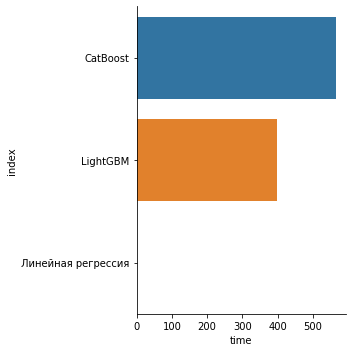

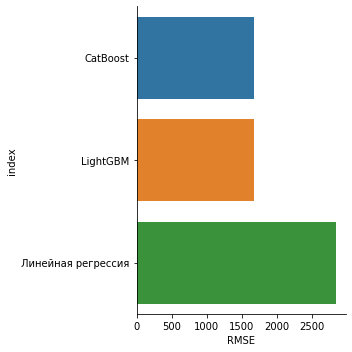

In [36]:
sns.catplot(x='time', y='index', kind="bar", data=df_res)
sns.catplot(x='RMSE', y='index', kind='bar', data=df_res)
plt.show()

### Вывод:
 - Лучше всех отработала LightGBM: быстро и RMSE на уровне CatBoost
 - CatBoost долше всех обучался, но результат относительно не плохой
 - Линейная регрессия отработала молниеносно, но RMSE чуть ли не в два раза превышает

P.S.: Можно было еще перебором гиперпараметров или gridsearchcv попробовать улучшить результат, но это было бы на много дольше...

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей